# Simulating Language 23, Extending Bayesian Iterated Learning (lab) (some answers)

This simulation implements a simplified version of the language model from Kirby, Dowman & Griffiths (2007) using an explicit agent-based simulation, and embeds this language model in a slightly more sophisticated population model.

In [1]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from math import log, log1p, exp
from scipy.special import logsumexp

Following Kirby, Dowman & Griffiths (2007), we assume a language is made up of a set of *variables*, each of which can exist in a number of different *variant* forms. This is a rather general characterisation that actually applies well to a number of linguistic phenomena. For example, we can think of the variables as different syntactic categories, and the variants as word orders. Alternatively, the variables could be verb-meanings and the variants different realisations of the past tense, and so on. Agents will produce (and learn from) data which simply exemplifies which variant they have for a particular variable (with the possibility of noise on transmission). We will group languages into two classes: regular languages (where the same variant is used for all variables) and irregular languages (where more than one variant is used).

As usual, the new code starts with a set of parameter declarations:

In [2]:
learning = 'sample'     # The type of learning ('map' or 'sample')
bias = log(0.6)         # The preference for regular languages
variables = 2           # The number of different variables in the language
variants = 2            # The number of different variants each variable can take
noise = log(0.05)       # The probability of producing the wrong variant
population_size = 1000  # Size of population
teachers = 'single'     # Either 'single' or 'multiple'
method = 'chain'        # Either 'chain' or 'replacement'

## Functions for dealing with log probabilities

Here are our standard functions for dealing with logs, as before.

In [3]:
def log_subtract(x,y):
    return x + log1p(-exp(y - x))

def normalize_logprobs(logprobs):
    logtotal = logsumexp(logprobs) #calculates the summed log probabilities
    normedlogs = []
    for logp in logprobs:
        normedlogs.append(logp - logtotal) #normalise - subtracting in the log domain
                                        #equivalent to dividing in the normal domain
    return normedlogs
 
def log_roulette_wheel(normedlogs):
    r = log(random.random()) #generate a random number in [0,1), then convert to log
    accumulator = normedlogs[0]
    for i in range(len(normedlogs)):
        if r < accumulator:
            return i
        accumulator = logsumexp([accumulator, normedlogs[i + 1]])

def wta(items):
    maxweight = max(items)
    candidates = []
    for i in range(len(items)):
        if items[i] == maxweight:
            candidates.append(i)
    return random.choice(candidates)

## Production of data

In [4]:
def produce(language):
    variable = random.randrange(len(language))
    correct_variant = language[variable]
    if log(random.random()) > noise:
        return [variable, correct_variant]
    else:
        possible_noise_variants = list(range(variants))
        possible_noise_variants.remove(correct_variant)
        noisy_variant = random.choice(possible_noise_variants)
        return [variable, noisy_variant]

The function produce takes a language, selects a random variable, and produces the relevant variant from the language.

- By looking at this code, can you tell how languages are represented in the simulation?
- Can you see how ‘noise’ - errors on production - works?

## Classifying languages

In this language model, prior probability is determined by language class: regular languages differ from irregular languages in their prior probability, and ultimately we are interested in the proportion of our simulated population who use regular languages. We therefore need a function to take a language and classify it as regular or not - the function `regular` does this. We also want to be able to calculate the proportion of individuals in a population who use a regular language (for plotting simulation results), which is done by `proportion_regular_language`.

In [5]:
def regular(language):
    regular = True
    first_variant = language[0]
    for variant in language:
        if variant != first_variant:
            regular = False
    return regular

def proportion_regular_language(population):
    regular_count = 0
    for agent in population:
        if regular(agent):
            regular_count += 1
    return regular_count / float(len(population))

## The Bayesian bits

In [6]:
def logprior(language):
    if regular(language):
        number_of_regular_languages = variants
        return bias - log(number_of_regular_languages) #subtracting logs = dividing
    else:
        number_of_irregular_languages = pow(variants, variables) - variants
        return log_subtract(0, bias) - log(number_of_irregular_languages)
        # log(1) is 0, so log_subtract(0, bias) is equivalent to (1 - bias) in the
        # non-log domain

The function `logprior` returns the prior probability (as a log probability) of a particular language. The strength of preference for regular languages depends on the simulation parameter `bias` - if bias is over 0.5 (when converted back from a log probability), regular languages have higher prior probability.

- Why are we dividing the bias by the number of regular and irregular languages in this function? Check you understand how these numbers are calculated.
- How does this function differ from the prior from the Kirby, Dowman & Griffiths (2007) paper? (Hint: consider the case of more than two variables.)

In [7]:
def loglikelihood(data, language):
    loglikelihoods = []
    logp_correct = log_subtract(0, noise) #probability of producing correct form
    logp_incorrect = noise - log(variants - 1) #logprob of each incorrect variant
    for utterance in data:
        variable = utterance[0]
        variant = utterance[1]
        if variant == language[variable]:
            loglikelihoods.append(logp_correct)
        else:
            loglikelihoods.append(logp_incorrect)
    return sum(loglikelihoods) #summing log likelihoods = multiplying likelihoods

The function `loglikelihood` takes a language and a list of data and works out the (log) likelihood of the data given the language. We allows some small probability (given by the simulation parameter `noise`) that a speaker will produce the ‘wrong’ variant, i.e. a variant other than that specified by their language.

## Learning

Bayesian learners calculate the posterior probability of each language based on some data, then select a language (‘learn’) based on those posterior probabilities. `learn` implements this. As discussed in the lecture, there are two ways you could select a language based on the posterior probability distribution:
- You could pick the best language - i.e. the language with the highest posterior probability. This is called MAP (“maximum a posteriori”) learning.
- Alternatively, you could pick a language probabilistically based on its posterior probability, without necessarily going for the best one every time (e.g. if language 0 has twice the posterior probability of language 1, you are twice as likely to pick it). This is called sampling (for “sampling from the posterior distribution”).

The next bit of code implements both these ways of learning, using the familiar `wta` function to do MAP learning and using `log_roulette_wheel` to do sampling (from previous labs, which assumed learners sample from the posterior). `all_languages` enumerates all possible languages for expressing `n` variables using a cute recursive method (don’t worry too much if you can’t figure out how it works, but you might get an idea if you figure out what steps it would take when called with different arguments, like `all_languages(0)`, `all_languages(1)` and so on). Finally, `learn` implements hypothesis selection.

In [8]:
def all_languages(n):
    if n == 0:
        return [[]]
    else:
        result = []
        smaller_langs = all_languages(n - 1)
        for l in smaller_langs:
            for v in range(variants):
                result.append(l + [v])
        return result

def learn(data):
    list_of_all_languages = all_languages(variables)
    list_of_posteriors = []
    for language in list_of_all_languages:
        this_language_posterior = loglikelihood(data, language) + logprior(language)
        list_of_posteriors.append(this_language_posterior)
    if learning == 'map':
        map_language_index = wta(list_of_posteriors)
        map_language = list_of_all_languages[map_language_index]
        return map_language
    if learning == 'sample':
        normalized_posteriors = normalize_logprobs(list_of_posteriors)
        sampled_language_index = log_roulette_wheel(normalized_posteriors)
        sampled_language = list_of_all_languages[sampled_language_index]
        return sampled_language

## The simulation

There are two main functions to actually carry out the relevant simulation runs. The first is `pop_learn`, creates a new population of a specified size who learn a language from data produced by an adult population. It calls on the `teachers` global parameter to decide whether these learners should learn from a single individual in the adult population, or whether they learn each utterance from a randomly-selected member of the adult population (i.e. learns from multiple teachers).
- How is the difference between single and multiple teachers implemented? In the multiple-teacher version, is each data item guaranteed to be produced by a separate teacher?

In [9]:
def pop_learn(adult_population,bottleneck,number_of_learners):
    new_population = []
    for n in range(number_of_learners):
        if teachers == 'single':
            potential_teachers = [random.choice(adult_population)]
        if teachers == 'multiple':
            potential_teachers = adult_population
        data = []
        for n in range(bottleneck):
            teacher = random.choice(potential_teachers)
            utterance = produce(teacher)
            data.append(utterance)
        learner_grammar = learn(data)
        new_population.append(learner_grammar)
    return new_population

`initial_population` is a subsidiary function which generates a population of a specified size of individuals speaking randomly-selected languages.

In [10]:
def initial_population(n):
    population = []
    possible_languages = all_languages(variables)
    for agent in range(n):
        language=random.choice(possible_languages)
        population.append(language)
    return population

The second main function is `iterate`, which is the top-level function which actually runs simulations. This function calls on the method `parameter`, to run either chain simulations (where a population consists of a series of generations, where the entire population is replaced at each generation) or replacement simulation (where a single individual is replaced at each ‘generation’). It returns a list of two things: the final population, and a (plottable) list of the proportion of each generation which uses a regular language.

In [11]:
def iterate(generations, bottleneck, report_every):
    population = initial_population(population_size)
    accumulator=[proportion_regular_language(population)]
    for g in range(1, generations + 1):
        if method == 'chain': # Replace whole population
            population = pop_learn(population, bottleneck, population_size)
        if method == 'replacement': #Replace one individual at a time
            population = population[1:]
            new_agent = pop_learn(population, bottleneck, 1)[0]
            population.append(new_agent)
        if (g % report_every == 0):
            print(g, end=" ") # This line is just to let you know the simulation is working.
                              # Delete it if it gets annoying! The "end" bit tells python not
                              # to add a new line each time.
            accumulator.append(proportion_regular_language(population))
    return population, accumulator

## Questions

**Note:** Running the simulations takes a little time, particularly if you run large populations for large numbers of generations. In general, you probably want to keep the bottleneck values between 1 and 10, in which case you should get representative results within 100 to 500 generations (for chain populations). Larger populations (e.g. 1000 individuals) generally give you cleaner results (have a think about why this is).

1. Using the default parameters (single teacher, chain method), check that you can replicate the standard results for sampling and MAP learners: convergence to the prior for samplers, exaggeration of the prior for MAP.

In [30]:
learning = 'sample'
results_sample = iterate(200, 5, 10)

learning = 'map'
results_map = iterate(200, 5, 10)

learning = 'sample'
results_sample_wide = iterate(200, 20, 10)

learning = 'map'
results_map_wide = iterate(200, 20, 10)

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 

Text(0,0.5,'proportion of regular languages')

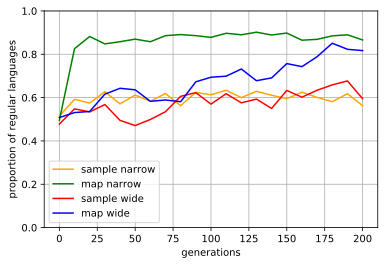

In [23]:
plt.plot(range(0,201,10), results_sample[1], color='orange', label='sample narrow')
plt.plot(range(0,201,10), results_map[1], color='green', label='map narrow')
plt.plot(range(0,201,10), results_sample_wide[1], color='red', label='sample wide')
plt.plot(range(0,201,10), results_map_wide[1], color='blue', label='map wide')
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.xlabel('generations')
plt.ylabel('proportion of regular languages')

2. What happens if you switch from single teachers to multiple teachers? Does the sampler result change? Does the MAP result change? How does the bottleneck effect these results?

In [24]:
teachers = 'multiple'

learning = 'sample'
results_sample_mult = iterate(200, 5, 10)

learning = 'map'
results_map_mult = iterate(200, 5, 10)

learning = 'sample'
results_sample_wide_mult = iterate(200, 20, 10)

learning = 'map'
results_map_wide_mult = iterate(200, 20, 10)

10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 

Text(0,0.5,'proportion of regular languages')

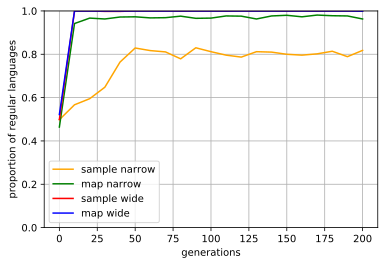

In [25]:
plt.plot(range(0,201,10), results_sample_mult[1], color='orange', label='sample narrow')
plt.plot(range(0,201,10), results_map_mult[1], color='green', label='map narrow')
plt.plot(range(0,201,10), results_sample_wide_mult[1], color='red', label='sample wide')
plt.plot(range(0,201,10), results_map_wide_mult[1], color='blue', label='map wide')
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.xlabel('generations')
plt.ylabel('proportion of regular languages')

3. Finally, what happens if you switch from the chain method to the replacement method? Don’t forget that each ‘generation’ in a replacement simulation just replaces a single individual, so you’ll have to run the simulations for lots more generations to get equivalent results to those you got under the chain method.

In [28]:
teachers = 'single'
method = 'replacement'

learning = 'sample'
results_sample_rep = iterate(200000, 5, 10000)

learning = 'map'
results_map_rep = iterate(200000, 5, 10000)

learning = 'sample'
results_sample_wide_rep = iterate(200000, 20, 10000)

learning = 'map'
results_map_wide_rep = iterate(200000, 20, 10000)

10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 

Text(0,0.5,'proportion of regular languages')

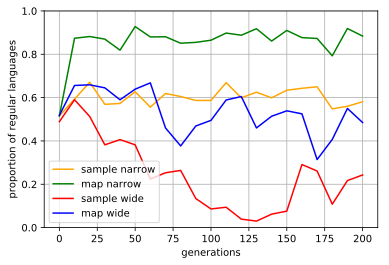

In [29]:
plt.plot(range(0,201,10), results_sample_rep[1], color='orange', label='sample narrow')
plt.plot(range(0,201,10), results_map_rep[1], color='green', label='map narrow')
plt.plot(range(0,201,10), results_sample_wide_rep[1], color='red', label='sample wide')
plt.plot(range(0,201,10), results_map_wide_rep[1], color='blue', label='map wide')
plt.legend()
plt.grid()
plt.ylim(0,1)
plt.xlabel('generations')
plt.ylabel('proportion of regular languages')